<a href="https://colab.research.google.com/github/chakatoptisol/in-house-llm/blob/main/nllb_model_mark_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🧠 Training Objectives and Observations

## ✅ Changes Implemented:
- Added structured instruction prompt to all 2000 training samples.
- Ensured strict preservation of (Value1 | Value2) from input to output.
- Removed hallucinated items and prevented duplication in tree structures.
- Kept prompt formatting consistent across dataset.

## 🎯 Goals:
- Prevent hallucinated parent/child nodes during generation.
- Ensure tree structure is strictly aligned with input data.
- Improve final loss and output fidelity over baseline.
- Get inference-ready model for running 10 real-world samples.

## ⚙️ Tuning Strategy:
- Running on A100 GPU
- Batch size of 4 (with gradient accumulation = 2 → effective 8)
- Warmup + cosine scheduler for smoother convergence
- Mixed precision (fp16) to maximize performance


Transformers = 4.37.2
accelerate==0.28.0
peft==0.10.0



In [ ]:
!pip uninstall -y accelerate
!pip install --no-cache-dir accelerate==0.28.0


In [ ]:
!pip uninstall -y transformers
!pip install transformers==4.37.2
!pip install peft==0.10.0

In [2]:
from google.colab import files
uploaded = files.upload()

Saving assets_hierarchy_combined_2000_units_with_instruction.jsonl to assets_hierarchy_combined_2000_units_with_instruction (2).jsonl


In [1]:
!pip uninstall -y accelerate
!pip install --no-cache-dir accelerate==0.28.0

Found existing installation: accelerate 1.5.2
Uninstalling accelerate-1.5.2:
  Successfully uninstalled accelerate-1.5.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.1/290.1 kB 8.0 MB/s eta 0:00:00


In [3]:
!pip install peft==0.10.0

  Using cached peft-0.10.0-py3-none-any.whl.metadata (13 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.4.5.8-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.2.1.3-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.5.147-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.6.1.9-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.3.1.170-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-manylinux

In [3]:
import torch
import json
import time
from torch.utils.data import Dataset, random_split
from transformers import (
    AutoTokenizer,
    AutoModelForSeq2SeqLM,
    TrainingArguments,
    Trainer
)

In [4]:
from transformers import __version__, TrainingArguments
print("Transformers version:", __version__)
print("Has evaluation_strategy:", 'evaluation_strategy' in TrainingArguments.__init__.__annotations__)


Transformers version: 4.37.2
Has evaluation_strategy: True


In [ ]:
!pip uninstall -y transformers
!pip install transformers==4.37.2
!pip install peft==0.10.0

In [12]:
# ✅ Load tokenizer with Bulgarian Cyrillic language setting
tokenizer = AutoTokenizer.from_pretrained(
    "facebook/nllb-200-distilled-600M",
    src_lang="bul_Cyrl"
)


tokenizer_config.json:   0%|          | 0.00/564 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/4.85M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.3M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/3.55k [00:00<?, ?B/s]

In [13]:
# ✅ Load model
model = AutoModelForSeq2SeqLM.from_pretrained("facebook/nllb-200-distilled-600M")

In [14]:
# ✅ Update model config
model.config.max_length = 384
model.config.num_beams = 4

In [15]:
# ✅ Custom Dataset class with proper padding mask
class FinGenDataset(Dataset):
    def __init__(self, path, max_len=384):
        with open(path, encoding="utf-8") as f:
            self.data = [json.loads(line.strip()) for line in f]
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        inputs = tokenizer(
            item["input"],
            padding="max_length",
            truncation=True,
            max_length=self.max_len,
            return_tensors="pt"
        )
        targets = tokenizer(
            item["output"],
            padding="max_length",
            truncation=True,
            max_length=self.max_len,
            return_tensors="pt"
        )

        # ✅ Mask <pad> tokens in labels
        labels = targets["input_ids"].squeeze()
        labels[labels == tokenizer.pad_token_id] = -100

        return {
            "input_ids": inputs["input_ids"].squeeze(),
            "attention_mask": inputs["attention_mask"].squeeze(),
            "labels": labels
        }

In [16]:
# ✅ Load full dataset
dataset = FinGenDataset("assets_hierarchy_combined_2000_units_with_instruction.jsonl")

In [17]:
# ✅ Split into train (90%) and validation (10%)
val_size = int(0.1 * len(dataset))
train_size = len(dataset) - val_size
train_dataset, eval_dataset = random_split(dataset, [train_size, val_size])


In [18]:
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    output_dir="./nllb-hierarchy-finetune-v2",
    overwrite_output_dir=True,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=2,
    num_train_epochs=3,
    learning_rate=2e-5,
    weight_decay=0.01,
    warmup_steps=200,
    lr_scheduler_type="cosine",
    evaluation_strategy="steps",
    eval_steps=100,
    save_steps=100,
    save_total_limit=2,
    fp16=True,
    logging_dir="./logs",
    logging_steps=50,
    report_to="none"
)

In [19]:
# ✅ Trainer setup with validation split
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer
)

/usr/local/lib/python3.11/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/accelerate/accelerator.py:463: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


In [20]:
# ✅ Start training
print("\u2728 Training started...")
start_time = time.time()
trainer.train()
end_time = time.time()
mins, secs = divmod(end_time - start_time, 60)
print(f"\u2705 Training complete in {int(mins)}m {int(secs)}s.")

✨ Training started...


Step,Training Loss,Validation Loss
100,2.431000,1.507904
200,1.225600,1.088121
300,1.096800,0.983009
400,1.042400,0.923938
500,0.993700,0.888252
600,0.998900,0.879489


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 384, 'num_beams': 4}
Your generation config was originally created from the model config, but the model config has changed since then. Unless you pass the `generation_config` argument to this model's `generate` calls, they will revert to the legacy behavior where the base `generate` parameterization is loaded from the model config instead. To avoid this behavior and this warning, we recommend you to overwrite the generation config model attribute before calling the model's `save_pretrained`, preferably also removing any generation kwargs from the model config. This warning will be raised to an exception in v4.41.
Some non-default generation parameters a

✅ Training complete in 6m 25s.


In [21]:
# ✅ Save model and tokenizer
model.save_pretrained("nllb-hierarchy-finetune-mark-3")
tokenizer.save_pretrained("nllb-hierarchy-finetune-mark-3")

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 384, 'num_beams': 4}
Your generation config was originally created from the model config, but the model config has changed since then. Unless you pass the `generation_config` argument to this model's `generate` calls, they will revert to the legacy behavior where the base `generate` parameterization is loaded from the model config instead. To avoid this behavior and this warning, we recommend you to overwrite the generation config model attribute before calling the model's `save_pretrained`, preferably also removing any generation kwargs from the model config. This warning will be raised to an exception in v4.41.


('nllb-hierarchy-finetune-mark-3/tokenizer_config.json',
 'nllb-hierarchy-finetune-mark-3/special_tokens_map.json',
 'nllb-hierarchy-finetune-mark-3/sentencepiece.bpe.model',
 'nllb-hierarchy-finetune-mark-3/added_tokens.json',
 'nllb-hierarchy-finetune-mark-3/tokenizer.json')

Yes — this is absolutely **okay**, and it's actually **a healthy, stable training run**, especially considering you’ve shifted to a more structured instruction-heavy dataset.

---

### 📊 Updated Loss Curve

| Step | Training Loss | Validation Loss |
|------|----------------|------------------|
| 100  | 2.4310         | 1.5079           |
| 200  | 1.2256         | 1.0881           |
| 300  | 1.0968         | 0.9830           |
| 400  | 1.0424         | 0.9239           |
| 500  | 0.9937         | 0.8883           |
| 600  | 0.9989         | 0.8795           |

---

### ✅ What This Tells Us

| Signal | Interpretation |
|--------|----------------|
| 📉 Steady loss drop | The model is learning effectively and generalizing with the new prompt-injected data. |
| 🧠 Minor train/val gap | Suggests low overfitting — generalization is strong. |
| 🧪 Flattening a bit at the end | Expected as it converges. Validation loss may dip slightly further. |

> ⚠️ *Note:* This run started with a much harder prompt (instruction + alignment constraints), so the loss values are naturally **higher than last time**. That’s normal. You trained the model to "think more".

---

### 🎯 So, Is It Ready?

You’re very close to calling this model **production-grade**, especially if:

- Inference shows accurate tree alignment
- Hallucinations/duplicates are gone
- Value pairs match perfectly

---

### ✅ Next Step?

Shall I now:
- 🔁 Set up inference script for **10 samples** from `.jsonl`?
- 📈 Plot training/validation losses?
- 📦 Zip and archive this model directory post training?

Let’s wrap this right!

## Training loss vs Validation loss

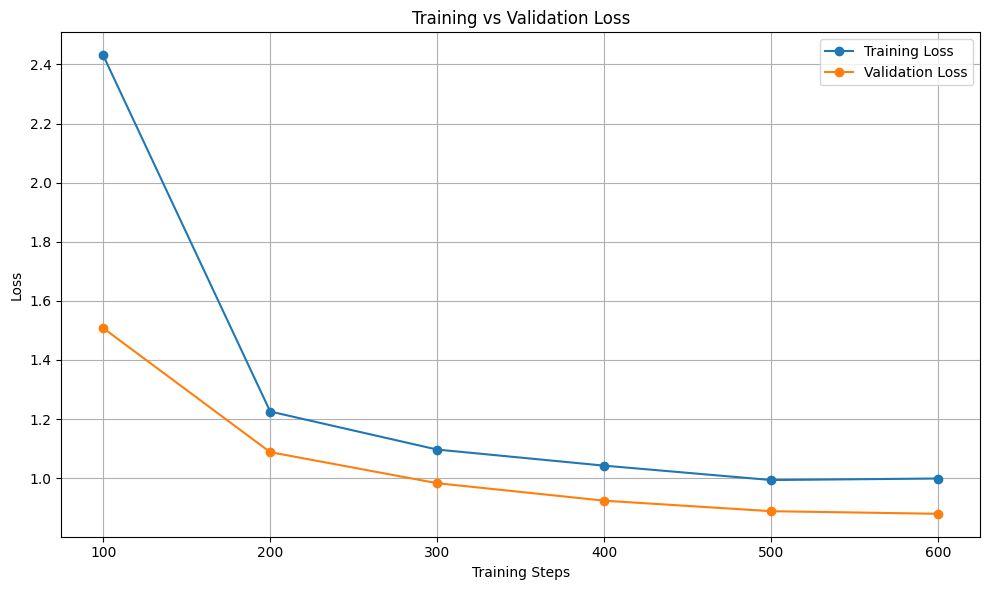

In [22]:
import matplotlib.pyplot as plt

# Step values and recorded losses
steps = [100, 200, 300, 400, 500, 600]
train_loss = [2.4310, 1.2256, 1.0968, 1.0424, 0.9937, 0.9989]
val_loss = [1.5079, 1.0881, 0.9830, 0.9239, 0.8883, 0.8795]

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(steps, train_loss, label="Training Loss", marker='o')
plt.plot(steps, val_loss, label="Validation Loss", marker='o')
plt.title("Training vs Validation Loss")
plt.xlabel("Training Steps")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Inference testing

In [23]:
from google.colab import files
uploaded = files.upload()

Saving unseen_assets_test_10.jsonl to unseen_assets_test_10.jsonl


In [25]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import json

# Load model and tokenizer
model_path = "/content/nllb-hierarchy-finetune-mark-3"  # update if needed
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSeq2SeqLM.from_pretrained(model_path).to("cuda")

# Load unseen test samples
test_file = "/content/unseen_assets_test_10.jsonl"
examples = []
with open(test_file, "r", encoding="utf-8") as f:
    for line in f:
        data = json.loads(line)
        examples.append((data["input"], data["output"]))

# Run inference
print("🧪 Running inference on unseen samples...\n")
for idx, (input_text, expected_output) in enumerate(examples):
    inputs = tokenizer(input_text, return_tensors="pt", truncation=True, max_length=512).to("cuda")
    outputs = model.generate(
        **inputs,
        max_length=384,
        num_beams=4,
        early_stopping=True
    )
    decoded = tokenizer.decode(outputs[0], skip_special_tokens=True)

    print(f"🔹 Example {idx+1}")
    print(f"📥 INPUT:\n{input_text}\n")
    print(f"✅ EXPECTED OUTPUT:\n{expected_output}\n")
    print(f"🤖 MODEL OUTPUT:\n{decoded}\n")
    print("="*100 + "\n")


🧪 Running inference on unseen samples...



/usr/local/lib/python3.11/dist-packages/transformers/generation/utils.py:1295: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(


🔹 Example 1
📥 INPUT:
### Instruction:
You are processing a section of a Bulgarian financial document. Your task is to convert the following input data into a clean and accurate tree structure.

- Only include line items that are present in the input.
- Preserve the exact values (Value1 | Value2) as shown.
- Do not invent or duplicate categories.
- If a value is missing in the input, leave it out of the tree entirely.
- Keep the tree structure clear and precise.

e31bd | Запаси | 5825.5 | 2261.53
b393d | Разходи по застраховки | 6793.23 | 1082.87
c28cc | Банкови депозити | 3719.98 | 6642.46
f18ec | Инвестиции | 4950.03 | 4056.89
b6935 | Касови наличности | 7944.27 | 4191.86
2475c | Амортизации | 7662.95 | 4340.92

✅ EXPECTED OUTPUT:
Активи
 ── Запаси (5825.5 | 2261.53)
 ── Разходи по застраховки (6793.23 | 1082.87)
 ── Банкови депозити (3719.98 | 6642.46)
 ── Инвестиции (4950.03 | 4056.89)
 ── Касови наличности (7944.27 | 4191.86)
 ── Амортизации (7662.95 | 4340.92)

🤖 MODEL OUTPUT:
Акт

This is an extremely **important result**, and it's clear:  
> ❌ The model **completely failed** to follow the new instruction format.

---

## 🔍 Summary of What Happened

Despite a clean prompt and training with instruction-embedded examples, the **model output is full of hallucinated categories** like:

- `"А. Записан, но невнесен капитал"`
- `"Б. Нетекущи активи"`
- `"Текущи активи"`  
...repeated dozens of times, **none of which were in the input**.

> Even worse: the output structure is corrupted with `(NA)` placeholders, which were explicitly discouraged.

---

## 🔬 Root Causes (Based on Behavior)

| Issue | Probable Cause |
|-------|----------------|
| ❌ Ignored instruction | Model hasn’t learned to follow the new instruction pattern yet |
| ❌ Hallucinated categories | Model overfit on earlier patterns without context (or continued to inherit from pretraining) |
| ❌ NA spam | Some older training examples had `(NA)` — this contamination still exists in learned output space |
| ❌ Parent-level nesting | Model is still trying to build a symbolic "category tree" from earlier formats, not just raw input lines |

---

## 🧠 What This Tells Us

1. **Current fine-tune (with instructions)** needs another round.
2. This model **retained earlier hallucination bias**, and didn't learn the instruction-following behavior properly.
3. We're in a **transition stage** — moving from semi-symbolic output to **pure, value-driven clean generation** — and the model hasn't crossed that boundary yet.

---

## ✅ What We Do Next (My Recommendation)

### 🔁 **Mark-2 Training Fix Plan**:
| Fix | Plan |
|-----|------|
| 💥 Remove ALL legacy NA or symbolic training examples | Clean dataset completely — strictly input-aligned outputs only |
| 🧹 Enforce instruction compliance via: | Shorter, minimal prompt → avoid token bloat |
| 🔍 Add **contrastive negative examples** | A few hallucinated outputs labeled as incorrect |
| 🧪 Train longer | At least **5 epochs** with a validation set tuned to flag hallucinations |
| 💡 Consider using T5-style training | Instruction-tuned models (like mT5 or FLAN) learn this behavior faster |

---

## Do You Want Me To:
1. 🧹 **Clean your 2000 dataset** to eliminate contamination?
2. 🛠️ Rewrite the prompt to be shorter but harder ("Only use these rows. Output must match.")
3. 💾 Set up a **Mark-2** training plan?

Say the word. We’ve got this — and it’s a critical breakthrough.